# Import libraries

In [ ]:
#basic library
import pandas
import matplotlib.pyplot as plt
import numpy as np

# Install tokenize
!pip install pyvi
from pyvi import ViTokenizer

# import necessary libraries for deep learning
import warnings
import keras
warnings.filterwarnings("ignore")
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from gensim.models.wrappers import FastText
from gensim.models import KeyedVectors
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# Load and preprocess data

In [ ]:
#load data
#file output.csv nay sinh ra tu chuong trinh scraping
data_path=r'/content/drive/MyDrive/Học tập/Introduce Data Science/Đố án/output.csv'
df= pandas.read_csv(data_path)

#preprocessing
df = df[pandas.notnull(df['postCotent'])]
df= df[df['forumName'] != 'Chuyện trò linh tinh™'] 
df=df[df['forumName'].map(len) >2]

labels=set(df['forumName'])

data=dict()
#Get labels
for label in labels:
  data[label]=[]
for index,row in df.iterrows():
  for label in labels:
    if row['forumName']==label:
      data[label].append(row['postCotent'])

for label in labels:
  print(label,': ',len(data[label]))

#convert label to num
def labelToNum(label):
  for (index, value) in enumerate(labels):
    if value==label:
      return index;
  return 0;
def numToLabel(num):
  for (index, value) in enumerate(labels):
    if index==num:
      return value;
  return data[data.keys()[0]];


df.head()

Phim / Nhạc / Sách :  1337
Điện thoại di động :  1596
4 bánh :  1026
Đồ điện tử & Thiết bị gia dụng :  1324


,postTitle,postCotent,forumName,postLink
0,Bán 8 Plus gold 64g còn bh ở didongviet 10 tháng,"Máy ngoại hình tốt, ko sướt cấn móp. Pin 100%....",Điện thoại di động,https://voz.vn/t/ban-8-plus-gold-64g-con-bh-o-...
1,Mới sắm con máy giặt LG AI DD ưng quá lên khoe...,"Hello mấy thím, nhân hôm không phải trông con ...",Đồ điện tử & Thiết bị gia dụng,https://voz.vn/t/moi-sam-con-may-giat-lg-ai-dd...
2,Những đồ thiết yếu cần lắp cho ô tô,Mời các bác vào tham luận cho vui. cái g...,4 bánh,https://voz.vn/t/nhung-do-thiet-yeu-can-lap-ch...
3,"Thái Mỹ Đình, Ép kính, Ép cáp, Thay Màn, Thay ...","Xin phép Add duyệt bài !!!\nGiúp đỡ , tạo điều...",Điện thoại di động,https://voz.vn/t/thai-my-dinh-ep-kinh-ep-cap-t...
4,"Điện thoại Samsung S9+ hàng ssvn, full box, hì...","Mới nâng cấp máy, cần bán hàng chính hãng SSV...",Điện thoại di động,https://voz.vn/t/dien-thoai-samsung-s9-hang-ss...


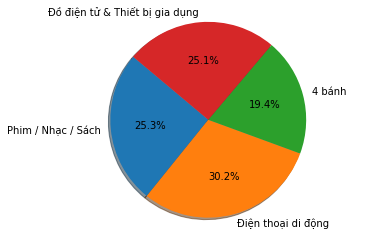

In [ ]:
# Data to plot
labels=labels
countings = []
for label in labels:
  countings.append(len(data[label]))

# Plot
plt.pie(countings, labels=labels,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

# Vectorize data

In [ ]:
X=list(df['postCotent'])
Y=list(df['forumName'])
Y=[labelToNum(i) for i in Y]

print(X[:10])
print(Y[:10])
print(Y[:10])

['Máy ngoại hình tốt, ko sướt cấn móp. Pin 100%. Máy đã dán ppf, ốp, kính cường lực.\nGiấy tờ hóa đơn mua còn đầy đủ. Trong tgian bảo hành còn được thay pin miễn phí. \nMáy đang dùng song song với XR, dư nên bán. Sdt liên hệ 0908 607 675.\nGiá chốt 7.400.000 vnđ\n. ', 'Hello mấy thím, nhân hôm không phải trông con giúp vợ, được dịp rảnh rỗi chém gió tí về mấy món đồ công nghệ mình sưu tầm được. Tôi là dân cơ khí nên mê mấy con gia dụng công nghệ vãi chưởng. Mà bị cái, mỗi lần tôi tha 1 món về thì vợ tôi cứ ầm ĩ bên tai. Nhà tôi thì không quá dư dả gì nhưng có con máy nào ra mà tốt thì tôi cũng ráng đi nghía rồi để tiền mua. Tổng cộng tôi đã tậu đc sương sương vài em như robot hút bụi Neato d5, máy rửa chén tự động Xiaomi Viomi, máy lọc không khí Beurer. Nhìn chung thì mấy món tôi mua giá cũng ko quá cao nhưng mà xài cũng đc. Đợt black friday trước, tôi quyết định chơi sang tự vác tiền mua con máy giặt của LG tên AI DD.\nĐợt tôi mua là cũng gan trời lắm vì vợ nhà không biết, tới khi biế

In [ ]:
def tokenize(text):
  return ViTokenizer.tokenize(text).split()

data=[]
for i in X:
  data.append(tokenize(i))

data[0]

['Máy',
 'ngoại_hình',
 'tốt',
 ',',
 'ko',
 'sướt',
 'cấn',
 'móp',
 '.',
 'Pin',
 '100',
 '%',
 '.',
 'Máy',
 'đã',
 'dán',
 'ppf',
 ',',
 'ốp',
 ',',
 'kính',
 'cường_lực',
 '.',
 'Giấy_tờ',
 'hóa_đơn',
 'mua',
 'còn',
 'đầy_đủ',
 '.',
 'Trong',
 'tgian',
 'bảo_hành',
 'còn',
 'được',
 'thay',
 'pin',
 'miễn_phí',
 '.',
 'Máy',
 'đang',
 'dùng',
 'song_song',
 'với',
 'XR',
 ',',
 'dư',
 'nên',
 'bán',
 '.',
 'Sdt',
 'liên_hệ',
 '0908',
 '607',
 '675',
 '.',
 'Giá',
 'chốt',
 '7.400.000',
 'vnđ',
 '.']

In [ ]:
word_tokenizer = Tokenizer() 
word_tokenizer.fit_on_texts(data)  

X= word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [ ]:
MAX_SEQ_LENGTH = 100
X_padded = pad_sequences(X, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [ ]:
EMBEDDING_SIZE  = 300  # each word in fast model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

#link dowload: https://thiaisotajppub.s3-ap-northeast-1.amazonaws.com/publicfiles/baomoi.window2.vn.model.bin.gz
path = '/content/drive/MyDrive/Học tập/Introduce Data Science/word2ve/baomoi.window2.vn.model.bin'
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)


EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [ ]:
Y= to_categorical(Y)

# Build model


In [ ]:
rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(Bidirectional(LSTM(64, 
              return_sequences=False  # True - return whole sequence; False - return single output of the end of the sequence
)))

rnn_model.add(Dense(4, activation='softmax'))

In [ ]:
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          9052500   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 9,239,896
Trainable params: 9,239,896
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

# Train model

In [103]:
rnn_training = rnn_model.fit(X_padded, Y, batch_size=128, epochs=10)

Epoch 1/10
42/42 [==============================] - 30s 628ms/step - loss: 1.1940 - acc: 0.4908
Epoch 2/10
42/42 [==============================] - 26s 623ms/step - loss: 0.5138 - acc: 0.8271
Epoch 3/10
42/42 [==============================] - 28s 670ms/step - loss: 0.2558 - acc: 0.9186
Epoch 4/10
42/42 [==============================] - 26s 621ms/step - loss: 0.1646 - acc: 0.9465
Epoch 5/10
42/42 [==============================] - 26s 617ms/step - loss: 0.1133 - acc: 0.9660
Epoch 6/10
42/42 [==============================] - 26s 629ms/step - loss: 0.0874 - acc: 0.9748
Epoch 7/10
42/42 [==============================] - 26s 624ms/step - loss: 0.0782 - acc: 0.9784
Epoch 8/10
42/42 [==============================] - 26s 620ms/step - loss: 0.0599 - acc: 0.9813
Epoch 9/10
42/42 [==============================] - 26s 620ms/step - loss: 0.0396 - acc: 0.9919
Epoch 10/10
42/42 [==============================] - 26s 625ms/step - loss: 0.0337 - acc: 0.9909


# Save model

In [104]:
#chon thu muc can luu
rnn_model.save('/content/drive/MyDrive/Học tập/Introduce Data Science/model.h5')

# Test model

In [105]:
test='Điện thoại Iphone10 vừa ra mắt thật đẹp muốn mua mà không có tiền'

def embedding(text):
  text= ViTokenizer.tokenize(text).split(text)
  
  text = word_tokenizer.texts_to_sequences(text)
  
  
  text= pad_sequences(text, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

  return text;

test=embedding(test)

rs=rnn_model.predict(test)
rs
#ket qua => xac suat thuoc lop 1 la 0.86 => thuoc lop 1

array([[0.03097977, 0.9216357 , 0.01139944, 0.0359851 ]], dtype=float32)

In [106]:
# lay nhan cua lop 1
numToLabel(1)

'Điện thoại di động'